In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, GlobalMaxPooling1D, LSTM, GRU
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

np.random.seed(0)
tf.random.set_seed(0)

2024-07-16 17:17:00.849051: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-16 17:17:01.599517: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-16 17:17:01.948508: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-16 17:17:02.037679: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-16 17:17:02.540503: I tensorflow/core/platform/cpu_feature_guar

In [2]:
from sklearn.metrics import mean_absolute_percentage_error

In [4]:
# !wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2024-07-16 17:17:29--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.21.23.210, 172.67.213.166, 2606:4700:3031::6815:17d2, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.21.23.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0.002s  

2024-07-16 17:17:30 (1.11 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [5]:
df = pd.read_csv('airline_passengers.csv', index_col='Month', parse_dates=True)

In [6]:
df['LogPassengers'] = np.log(df['Passengers'])

In [7]:
Ntest = 12
train = df.iloc[:-Ntest]
test = df.iloc[-Ntest:]

In [8]:
# boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [9]:
df['DiffLogPassengers'] = df['LogPassengers'].diff()

In [10]:
# Make supervised dataset
series = df['DiffLogPassengers'].dropna().to_numpy()

T = 10
X = []
Y = []
for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)
  y = series[t+T]
  Y.append(y)

X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (133, 10, 1) Y.shape (133,)


In [11]:
Xtrain, Ytrain = X[:-Ntest], Y[:-Ntest]
Xtest, Ytest = X[-Ntest:], Y[-Ntest:]

In [12]:
# RNN
i = Input(shape=(T, 1))
x = LSTM(24)(i)
x = Dense(1)(x)
model = Model(i, x)

In [13]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 10, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 24)             │         2,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            25 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,521 (9.85 KB)

 Trainable params: 2,521 (9.85 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [15]:
r = model.fit(
  Xtrain,
  Ytrain,
  epochs=100,
  validation_data=(Xtest, Ytest)
)

Epoch 1/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 136ms/step - loss: 0.0118 - val_loss: 0.0117
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0113 - val_loss: 0.0115
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0111 - val_loss: 0.0112
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0110 - val_loss: 0.0109
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0108 - val_loss: 0.0107
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0107 - val_loss: 0.0104
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0104 - val_loss: 0.0102
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0102 - val_loss: 0.0099
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0099 - val_loss: 0.0096
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0097 - val_loss: 0.0092
Epoch 11/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0094 - val_loss: 0.0087
Epoch 12/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0090 - val_l

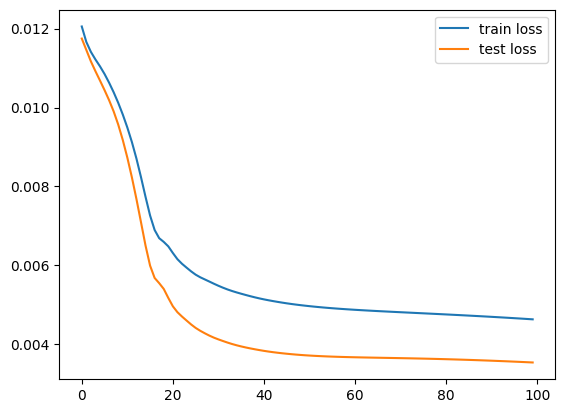

In [17]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()

In [18]:
train_idx[:T+1] = False # first T+1 values are not predictable

In [19]:
Ptrain = model.predict(Xtrain).flatten()
Ptest = model.predict(Xtest).flatten()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [20]:
# Needed to compute un-differenced predictions
df['ShiftLogPassengers'] = df['LogPassengers'].shift(1)
prev = df['ShiftLogPassengers']

In [21]:
# Last-known train value
last_train = train.iloc[-1]['LogPassengers']

In [22]:
# 1-step forecast
df.loc[train_idx, '1step_train'] = prev[train_idx] + Ptrain
df.loc[test_idx, '1step_test'] = prev[test_idx] + Ptest

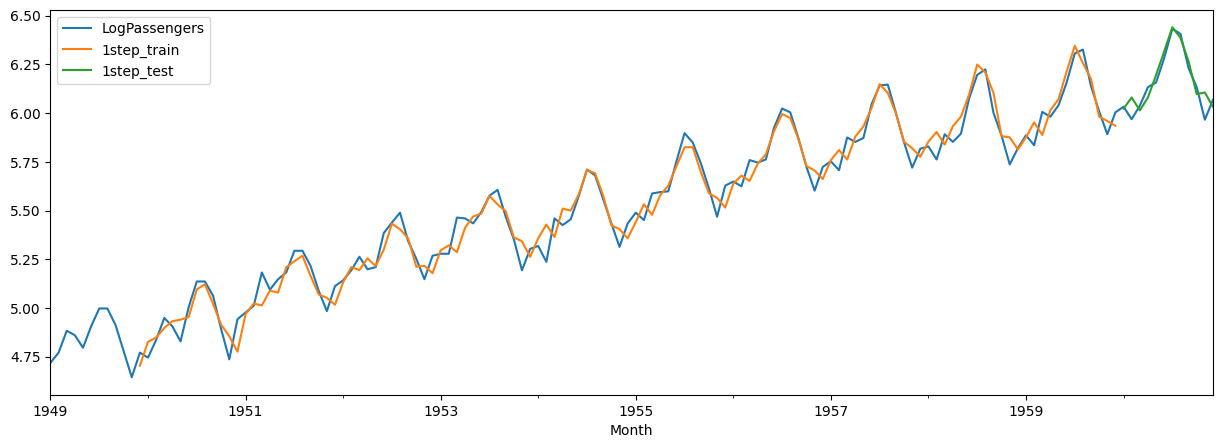

In [23]:
# plot 1-step forecast
df[['LogPassengers', '1step_train', '1step_test']].plot(figsize=(15, 5))

In [24]:
# multi-step forecast
multistep_predictions = []

# first test input
last_x = Xtest[0]

while len(multistep_predictions) < Ntest:
  p = model.predict(last_x.reshape(1, -1, 1))[0]
  
  # update the predictions list
  multistep_predictions.append(p)
  
  # make the new input
  last_x = np.roll(last_x, -1)
  last_x[-1] = p

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


In [25]:
# save multi-step forecast to dataframe
df.loc[test_idx, 'multistep'] = last_train + np.cumsum(multistep_predictions)

<Axes: xlabel='Month'>

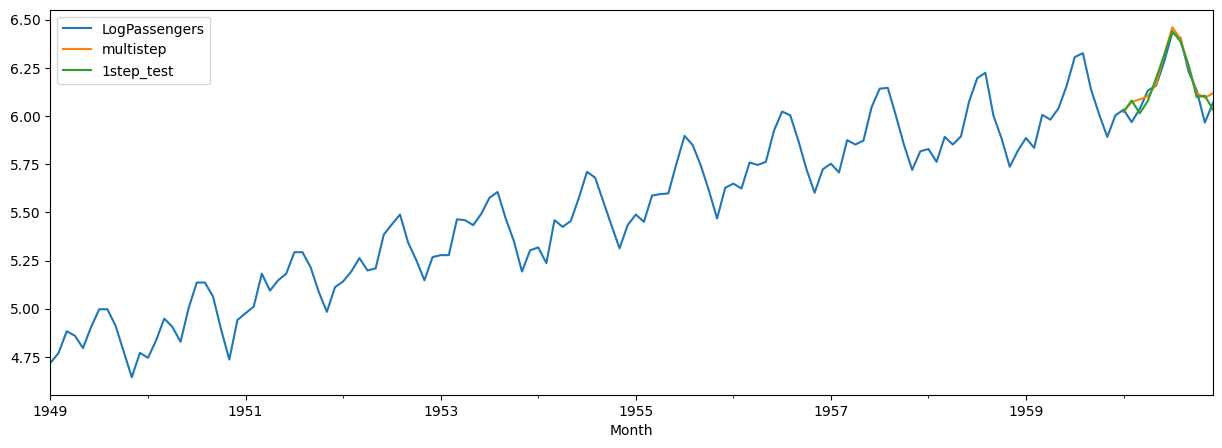

In [26]:
# plot 1-step and multi-step forecast
df[['LogPassengers', 'multistep', '1step_test']].plot(figsize=(15, 5))

In [27]:
# make multi-output supervised dataset
Tx = T
Ty = Ntest
X = []
Y = []
for t in range(len(series) - Tx - Ty + 1):
  x = series[t:t+Tx]
  X.append(x)
  y = series[t+Tx:t+Tx+Ty]
  Y.append(y)

X = np.array(X).reshape(-1, Tx, 1)
Y = np.array(Y).reshape(-1, Ty)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (122, 10, 1) Y.shape (122, 12)


In [28]:
Xtrain_m, Ytrain_m = X[:-1], Y[:-1]
Xtest_m, Ytest_m = X[-1:], Y[-1:]

In [29]:
# RNN
i = Input(shape=(Tx, 1))
x = LSTM(24, return_sequences=True)(i)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

In [36]:
check_point = tf.keras.callbacks.ModelCheckpoint(
    'best_model.keras', monitor='val_loss', save_best_only=True)

In [37]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [38]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=300,
  validation_data=(Xtest_m, Ytest_m),
  callbacks=[check_point],
)

Epoch 1/300


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - loss: 0.0116 - val_loss: 0.0118
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0115 - val_loss: 0.0116
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 0.0113 - val_loss: 0.0112
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - loss: 0.0113 - val_loss: 0.0111
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - loss: 0.0113 - val_loss: 0.0110
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0112 - val_loss: 0.0109
Epoch 8/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - loss: 0.0112 - val_loss: 0.0108
Epoch 9/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - loss: 0.0111 - val_loss: 0.0108
Epoch 10/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - loss: 0.0111 - val_loss: 0.0108
Epoch 11/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 0.0110 - val_loss: 0.0108
Epoch 12/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 0.0110 - val_loss: 0.010

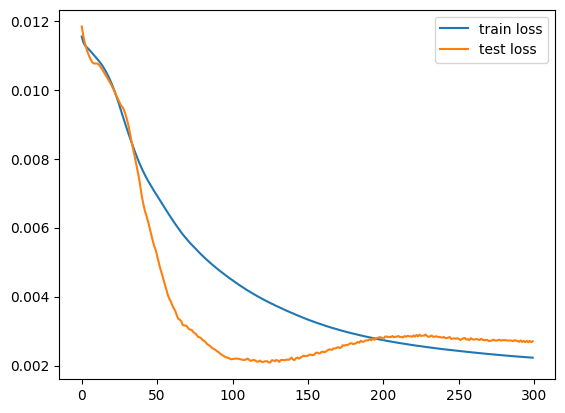

In [39]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()

In [40]:
# load best model
best_model = tf.keras.models.load_model('best_model.keras')

In [41]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


In [42]:
Ptrain.shape, Ptest.shape

((121, 12), (1, 12))

In [43]:
Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

In [44]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput'] = last_train + \
  np.cumsum(Ptest)

<Axes: xlabel='Month'>

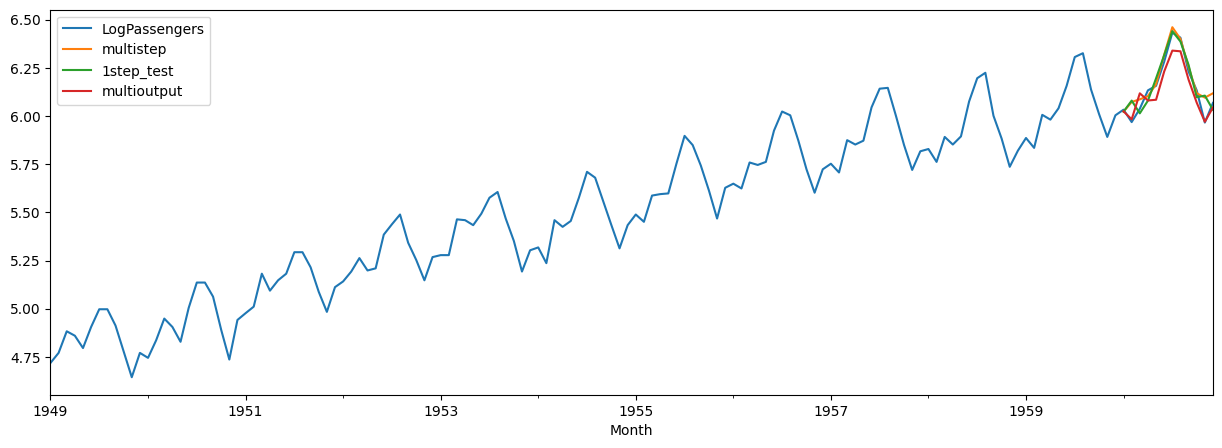

In [45]:
# plot all forecasts
cols = ['LogPassengers', 'multistep', '1step_test', 'multioutput']
df[cols].plot(figsize=(15, 5))

In [46]:
# RNN multiple LSTM layers
i = Input(shape=(Tx, 1))
x = LSTM(16, return_sequences=True)(i)
x = LSTM(16, return_sequences=True)(x)
x = GlobalMaxPooling1D()(x)
x = Dense(Ty)(x)
model = Model(i, x)

In [47]:
check_point = ModelCheckpoint(
    'best_model.keras', monitor='val_loss', save_best_only=True)

In [48]:
model.compile(
  loss='mse',
  optimizer='adam',
)

In [49]:
r = model.fit(
  Xtrain_m,
  Ytrain_m,
  epochs=300,
  validation_data=(Xtest_m, Ytest_m),
  callbacks=[check_point],
)

Epoch 1/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 5s 251ms/step - loss: 0.0116 - val_loss: 0.0112
Epoch 2/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0115 - val_loss: 0.0113
Epoch 3/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 4/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - loss: 0.0114 - val_loss: 0.0114
Epoch 5/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0114 - val_loss: 0.0115
Epoch 6/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 7/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 8/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0113 - val_loss: 0.0114
Epoch 9/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0112 - val_loss: 0.0114
Epoch 10/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - loss: 0.0112 - val_loss: 0.0113
Epoch 11/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 0.0112 - val_loss: 0.0112
Epoch 12/300
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step - loss: 0.0111 - val_l

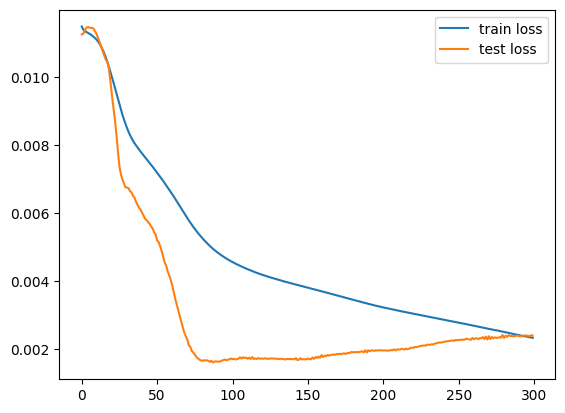

In [50]:
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='test loss')
plt.legend()

In [51]:
best_model = tf.keras.models.load_model('best_model.keras')

In [52]:
Ptrain = model.predict(Xtrain_m)
Ptest = model.predict(Xtest_m)

Ptrain = Ptrain[:,0]
Ptest = Ptest[0]

1/4 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/stepWARNING:tensorflow:5 out of the last 23 calls to <function TensorFlowTrainer.make_predict_function.<locals>.one_step_on_data_distributed at 0x7f2087fb7a60> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


In [53]:
# save multi-output forecast to dataframe
df.loc[test_idx, 'multioutput2'] = last_train + \
  np.cumsum(Ptest)

<Axes: xlabel='Month'>

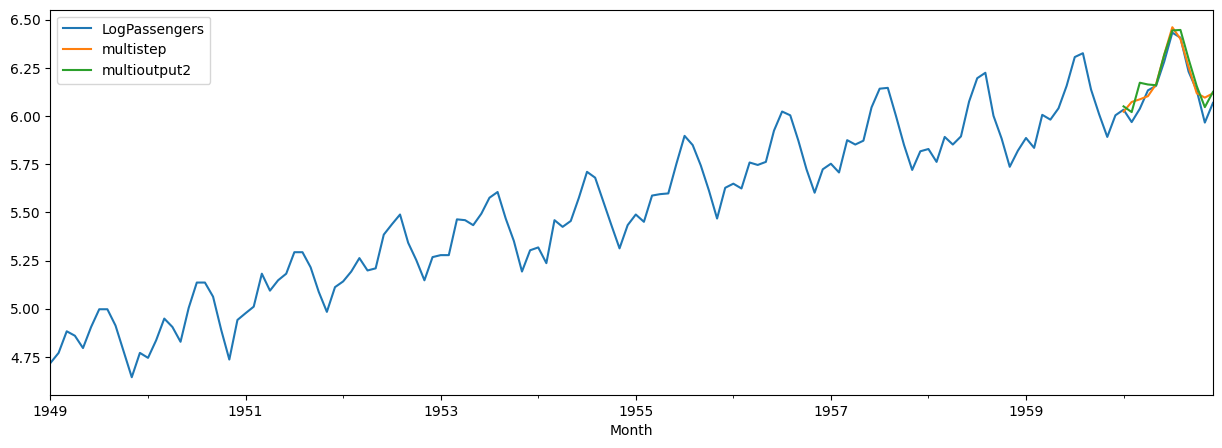

In [54]:
# plot all forecasts
cols = ['LogPassengers', 'multistep', 'multioutput2']
df[cols].plot(figsize=(15, 5))

In [55]:
# MAPE
test_log_pass = df.iloc[-Ntest:]['LogPassengers']
mape1 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multistep'])
print("multi-step MAPE:", mape1)
mape2 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput'])
print("multi-output MAPE:", mape2)
mape3 = mean_absolute_percentage_error(
    test_log_pass, df.loc[test_idx, 'multioutput2'])
print("multi-output (2 LSTMs) MAPE:", mape3)

multi-step MAPE: 0.006755865366194998
multi-output MAPE: 0.0077340561074942605
multi-output (2 LSTMs) MAPE: 0.007496366261747761
